In [ ]:
#IMPORTS
import os
import re
import gc
import sys
import nltk
import json
import time
import torch
import random
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import collections, functools, operator
from sklearn.svm import SVC 
from tensorflow import keras
from datasets import Dataset
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
#from transformers import BertTokenizer, BigBirdTokenizer, DistilBertTokenizer, TFBertModel, BigBirdForSequenceClassification, TFDistilBertModel, \
#DistilBertForSequenceClassification, BertConfig, DistilBertConfig, pipeline, Trainer, TrainingArguments, EvalPrediction, AutoTokenizer
from transformers import BigBirdTokenizer, BigBirdForSequenceClassification, Trainer, TrainingArguments, EvalPrediction, AutoTokenizer

In [ ]:
!nvidia-smi

In [ ]:
#TEXT CORPUS CREATION
COMM_DIRECTORY = '/kaggle/input/licenses/Comm'
NONCOMM_DIRECTORY = '/kaggle/input/licenses/NonC'

stop_words = set(stopwords.words('english'))

def tokkenizer(directory):
    text_corpus = ''
    sentences = []
    for file in os.listdir(directory):
        with open(os.path.join(directory, file)) as json_file:
            json_corpus = json.load(json_file)
            temp_corpus = json_corpus['licenseText']
            filt = r"[\n\-\=\\\/\t_`~¤•#\xa0–—]"
            temp_corpus = re.sub(filt, ' ', temp_corpus)
            temp_corpus = re.sub(r" +", ' ', temp_corpus)
            sentences.append(temp_corpus)
            text_corpus += temp_corpus

    token_text = word_tokenize(text_corpus)      
    token_text_stop = [w for w in token_text if not w.lower() in stop_words]
    return token_text, token_text_stop, sentences, text_corpus

comm_tokens, comm_tokens_stop, comm_sentences, comm_corpus = tokkenizer(COMM_DIRECTORY)
noncomm_tokens, noncomm_tokens_stop, noncomm_senteces, noncomm_corpus = tokkenizer(NONCOMM_DIRECTORY)

In [ ]:
#TEXT CORPUS CREATION
COMM_DIRECTORY = '/kaggle/input/licenses/comm_noncomm_data/comm'
NONCOMM_DIRECTORY = '/kaggle/input/licenses/comm_noncomm_data/noncomm'

COMM_DIRECTORY_GEN = '/kaggle/input/licenses/comm_noncomm_data/comm_gen'
NONCOMM_DIRECTORY_GEN = '/kaggle/input/licenses/comm_noncomm_data/noncomm_gen'

stop_words = set(stopwords.words('english'))

def tokkenizer(directory):
    text_corpus = ''
    for file in os.listdir(directory):
        try: #some files are encoded in ANSI
            with open(os.path.join(directory, file)) as txt_file:
                temp_corpus = txt_file.read()
        except:
            with open(os.path.join(directory, file), encoding="cp1252") as txt_file:
                temp_corpus = txt_file.read()
                
        filt = r"[\n\-\=\\\/\t_`~¤•#\xa0–—]"
        temp_corpus = re.sub(filt, ' ', temp_corpus)
        temp_corpus = re.sub(r" +", ' ', temp_corpus)
        text_corpus += temp_corpus
                
    token_text = word_tokenize(text_corpus)
    sentences = sent_tokenize(text_corpus)
    token_text_stop = [w for w in token_text if not w.lower() in stop_words]
    return token_text, token_text_stop, sentences, text_corpus

comm_tokens, comm_tokens_stop, comm_sentences, comm_corpus = tokkenizer(COMM_DIRECTORY_GEN)
noncomm_tokens, noncomm_tokens_stop, noncomm_sentences, noncomm_corpus = tokkenizer(NONCOMM_DIRECTORY_GEN)

In [ ]:
#WORD EMBEDDING
!wget https://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove*.zip
!rm glove*.zip

In [ ]:
# CREATE EMBEDDINGS DICTIONARY FROM TEXT
filepath = '/kaggle/working/glove.840B.300d.txt'

def embedding_for_vocab(filepath, text, embedding_dim):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size, embedding_dim))
  
    with open(filepath, encoding="utf8") as file:
        for line in file:
            word, *vector = line.split()
            try:
                float(vector[0])
                if word in word_index:
                    idx = word_index[word]
                    embedding_matrix_vocab[idx] = np.array(vector, dtype=np.float32)
            except:
                continue
    return embedding_matrix_vocab, tokenizer

embedding_dim = 300
comm_embeddings, comm_tokenizer = embedding_for_vocab(filepath, comm_sentences, embedding_dim)
noncomm_embeddings, noncomm_tokenizer = embedding_for_vocab(filepath, noncomm_sentences, embedding_dim)

In [84]:
def sentences_to_embedings(texts, embedded_vectors, tokenizer, label, embedding_dim=300):
    all_sent_lenght = len(texts)
    all_embeddings = np.zeros(shape=(all_sent_lenght, embedding_dim))
    labels = np.full((all_sent_lenght, 1), label)

    for i, sentence in enumerate(texts):
        sent_lenght = len(sentence.split())
        embeddings = np.zeros(shape=(sent_lenght, embedding_dim))
        exceptions = 0
        for j, word in enumerate(sentence.split()):
            try:
                word = re.sub('[^a-z]', '', word.lower())
                idx = tokenizer.word_index[word]
                embeddings[j] = embedded_vectors[i]
            except:
                exceptions =+ 1
                continue    
        all_embeddings[i] = np.sum(embeddings, axis=0)/sent_lenght - exceptions
    return all_embeddings, labels 

comm_embedings, comm_labels = sentences_to_embedings(comm_sentences, comm_embeddings, comm_tokenizer, 1)
noncomm_embedings, noncomm_labels = sentences_to_embedings(noncomm_sentences, comm_embeddings, noncomm_tokenizer, 0)

In [86]:
def pca_on_data(data, dimension=2):
    pca = PCA(n_components=dimension)
    pca.fit(data)
    return pca.transform(data)

comm_embedings_pca = pca_on_data(comm_embedings)
noncomm_embedings_pca = pca_on_data(noncomm_embedings)

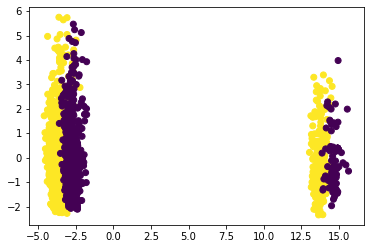

In [87]:
x = np.concatenate((comm_embedings_pca, noncomm_embedings_pca))
y = np.concatenate((comm_labels, noncomm_labels))
fig, ax = plt.subplots()
ax.scatter(x[:,0], x[:,1], c=y)

In [ ]:
#SVM
y = np.concatenate((comm_labels, noncomm_labels))
X = np.concatenate((comm_embedings, noncomm_embedings))
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

In [ ]:
#SENTIMENT ANALYSIS
def sentiment_analizer(corpus, text):
    sia = SentimentIntensityAnalyzer()
    corpus_sent = corpus.split('. ')
    corpus_sent_filt = [sent for sent in corpus_sent if len(sent.split()) > 3]
    scores = list(map(lambda x: sia.polarity_scores(x), corpus_sent_filt))
    result = dict(functools.reduce(operator.add, map(collections.Counter, scores)))
    result = {key: value / len(scores) for key, value in result.items()}
    print(text)
    print(result)

sentiment_analizer(comm_corpus, 'COMMERCIONAL')
sentiment_analizer(noncomm_corpus, 'NONCOMMERCIONAL')

In [ ]:
#CREATE WORD CLOUD
def create_word_cloud(text):
    comm_wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white', stopwords={''},
                    min_font_size = 10).generate(' '.join(text))

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(comm_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

create_word_cloud(comm_tokens)
create_word_cloud(noncomm_tokens)

In [ ]:
stop_words_modi = {'the', ',', 'of', '.', '-', 'to', 'this', 'in', 'that', 'a', '(', ')'}

In [ ]:
#MOST COMMON WORDS AND DIFFERENCES BETWEEN THEM
comm_most_common = nltk.FreqDist(w.lower() for w in comm_tokens)
noncomm_most_common = nltk.FreqDist(w.lower() for w in noncomm_tokens)
comm_top = comm_most_common.most_common(100)
noncomm_top = noncomm_most_common.most_common(100)

comm_only_words = list(map(lambda x: re.sub("[0-9(),' \"]",'' ,str(x)), comm_top))
noncomm_only_words = list(map(lambda x: re.sub("[0-9(),' \"]",'' ,str(x)), noncomm_top))

diff = list(set(comm_only_words) - set(noncomm_only_words))
diff_comparision = [[w, comm_most_common[w]/len(comm_most_common), noncomm_most_common[w]/len(noncomm_most_common)] for w in diff]

print(diff)
print()
print(diff_comparision)

In [ ]:
#CREATING DATAFRAME
def create_dataframe(data, label, limit=False, limit_lenght=30):
    df = pd.DataFrame()
    if limit:
        senteces_lenght = list(map(lambda x: len(x), comm_sentences))
        top_lenght_indexes = np.argpartition(senteces_lenght, -limit_lenght)[-limit_lenght:]
        array = np.array(comm_sentences)
        top_lenght = comm_array.take(top_lenght_indexes)
        df['text'] = top_lenght
        df['label'] = label
    else:    
        df['text'] = data
        df['label'] = label

    return df

comm_df = create_dataframe(comm_sentences, 1)
noncomm_df = create_dataframe(noncomm_sentences, 0)

data = pd.concat([comm_df, noncomm_df])
data.reset_index(inplace=True)
data = shuffle(data)

In [ ]:
#INITIALIZE DISTILBERT MODEL TENSORFLOW
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')



#MODEL CREATION
def create_model():
    inpt = Input(shape=(max_len,), dtype='int64')
    masks = Input(shape=(max_len,), dtype='int64')
    
    dbert_layer = dbert_model(inpt, attention_mask=masks)[0][:,0,:]
    dense = Dense(512, activation='relu')(dbert_layer)
    dropout = Dropout(0.5)(dense)
    pred = Dense(2, activation='sigmoid')(dropout) #sigmoid/softmax
    #concat_layer= Concatenate()([dense_bert, inpt2])
    model = tf.keras.Model(inputs=[inpt, masks], outputs=[pred, dropout, dbert_layer])
    
    #print(model.summary())
    return model

model=create_model()



#CREATING INPUT DATA
sia = SentimentIntensityAnalyzer()
input_ids=[]
attention_masks=[]
input_semantic=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent, add_special_tokens=True, max_length=max_len, pad_to_max_length=True, return_attention_mask=True, truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])
    input_semantic.append(list(sia.polarity_scores(sent).values()))

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
input_sent = np.array(input_semantic)
labels=np.array(labels)


#DATA SPLIT
train_input, test_input, train_label, test_label, train_mask, test_mask = train_test_split(input_ids, labels, attention_masks, test_size=0.2)

#log_dir='dbert_model'
#model_save_path='./dbert_model.h5'

#callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]


#MODEL CONFUGIRATION
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

history = model.fit([train_input, train_mask], train_label, batch_size=16, epochs=20, validation_data=([test_input, test_mask], test_label))

In [ ]:
#MODEL DATA
sentences = data['text']
labels = data['label']

In [ ]:
#LOADING PYTORCH DISTILBERT MODEL --- IN PROGRESS
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

tokens = list(map(lambda x: tokenizer(x, return_tensors="pt", truncation=False, max_length=None), sentences)) #MAX 128 tokens

In [ ]:
#LOADING BIGBIRD MODEL
model = BigBirdForSequenceClassification.from_pretrained('google/bigbird-roberta-base',
                num_labels = 2,
                return_dict=True)

tokenizer = AutoTokenizer.from_pretrained('google/bigbird-roberta-base')

In [ ]:
#CHOOSING CORRECT TOKENS LENGHT
tokens_lenght = list(map(lambda x: len(tokenizer.tokenize(x)), sentences))
percentil_50 = int(np.percentile(tokens_lenght, 50))
percentil_75 = int(np.percentile(tokens_lenght, 75))
max_len = percentil_75

In [ ]:
#DATA SPLIT
train_data_sent, test_data_sent, train_label_sent, test_label_sent = train_test_split(sentences, labels, test_size=0.2)

In [ ]:
#CREATING DATASET
df_train = pd.DataFrame({'text': train_data_sent, 'label': train_label_sent})
df_train.reset_index(drop=True, inplace=True)
train_dataset = Dataset.from_pandas(df_train)

df_test = pd.DataFrame({'text': test_data_sent, 'label': test_label_sent})
df_test.reset_index(drop=True, inplace=True)
test_dataset = Dataset.from_pandas(df_test)

In [ ]:
# define a function that will tokenize the model, and will return the relevant inputs for the model
def tokenization(batched_text):
    return tokenizer(batched_text['text'], padding = 'max_length', truncation=True, max_length = 4096)

train_data = train_dataset.map(tokenization, batched=True, batch_size=1)
test_data = test_dataset.map(tokenization, batched=True, batch_size=1)

train_data = train_dataset.map(tokenization)
test_data = test_dataset.map(tokenization)

# define accuracy metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    print(preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# define the training arguments
training_args = TrainingArguments(
    output_dir = '/kaggle/working/',
    num_train_epochs = 20,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 8,   
    per_device_eval_batch_size= 1,
    evaluation_strategy = "epoch",
    save_strategy = "steps",
    save_steps = 100,
    save_total_limit = 1,
    disable_tqdm = False,
    warmup_steps=0,
    weight_decay=0,
    learning_rate = 1e-5,
    fp16 = False,
    report_to='none'
)
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    compute_metrics=compute_metrics,
    eval_dataset=test_data
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
!nvidia-smi

In [ ]:
#CLEAR GPU MEMORY
del training_args
del trainer

gc.collect()

torch.cuda.empty_cache()

In [ ]:
trainer.train()